# RNNs and sequence processing

## Tutorial and homework 1: Sentiment Analysis

We will look at a simple example of sequence processing in sentiment analysis. Sentiment analysis is used to determine the emotion in a text. 

We will use a data set from IMDB consisting of movie reviews and are only interested if they are positive or negative (http://ai.stanford.edu/~amaas/data/sentiment/)

In addition to the libraries installed last time, we will also neet torchtext and datasets: 

pip install torchtext
pip install datasets

In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import torchtext.data
import torchtext.vocab

/Users/davebrunner/.local/share/virtualenvs/TSM_AdvDeLearn-rvOKaA_d/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/davebrunner/.local/share/virtualenvs/TSM_AdvDeLearn-rvOKaA_d/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/davebrunner/.local/share/virtualenvs/TSM_AdvDeLearn-rvOKaA_d/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated 

In [2]:
# should be version 0.18.0
print(torchtext.__version__)

0.18.0


In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True

### Loading and Preprocessing the IMDb Dataset

We’ll use datasets to load and preprocess the IMDb dataset (it is also available from torchtext)
- TorchText makes it easy to handle text data, including tokenization, padding, and batch generation.
- IMDB Dataset consists of movie reviews labeled as positive or negative.

In [4]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /Users/davebrunner/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Tue Oct  1 20:06:03 2024).


### Tokenizer
We will use a tokinizer to split the sentences in words. This tokenizer will normalize english text first and then extract the words.

In [5]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [6]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

### Token sequence
This will transfer the input data into sequences of words of a maximal length. While the model does not require the sequences to have the same length, it is needed for batch processing later.

We then split the data sets.

In [7]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [8]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

### Vocabulary

Next we build the vocabulary of all words in the set and add two special "words" for unknown and padding.

In [9]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

vocab.set_default_index(unk_index)

In [10]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [11]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [12]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [13]:
train_data[0]

{'label': tensor(1),
 'length': tensor(135),
 'ids': tensor([  180,     4,    14,    10,   191,   841,    34,     7,     2,   121,
            98,   816,    50,     8,  1516,     2,   380,     7,     2,   184,
             3,     8,   805,    14,    18,    10,     8,   805,  2246,   429,
             3,    12,   347,    15,     2,   388,  1025,     9,    16,    76,
             5,    64,     7, 11198,     3,     2,  9212,    17,   761,     4,
          7812,  5460,   198,    37,     4,     6,  3653,  3683,    17,   226,
             5, 11893,     3,    53,     7,    15,  3310,   354,     5,   689,
             4,     0,  5471,     3,  2706,  3826,     9,    16,   246,    13,
            14,    18,  1111,    33,    17,   126,   188,     8,    35,   597,
           181,    19,     5,    34,  3942,  1381,    13,     2,  5370,     3,
            32,  4228,    10,    41,  2825,     8,    37,     3,     2,  4411,
          1141,   213,  2655,     6, 16946,  3729,   590,  4845,     8,  2416,


### Creating Batches

Next we create batches out of the data with the same length and store the indices, actual length and label in the batch.

In [14]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [15]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [16]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

### RNN Model

Now we can build a model, we will use a RNN Model first. It includes

- Embedding Layer: Turns words into dense vectors.
- RNN Layer: A simple recurrent layer to capture sequence information.
- Fully Connected Layer: To classify the output.

In [17]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, 
                          bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]

        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction
  

In [18]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = RNN(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 7,394,102 trainable parameters


### Pretrained embeddings

The model will learn the embeddings too, which is a bit difficult from the limited data. Results will be much better if a pretrained model is used for that.

We will use glove (https://nlp.stanford.edu/projects/glove/)

The following code will download and cache the vectors. The data set is quite large so you can also omit this first...

In [20]:
vectors = torchtext.vocab.GloVe()

In [21]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding
del vectors

### Train function
Next we need the functions to train and evaluate the model.

In [22]:
def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

# calculate the accuracy, we could also use the metrics classes as in the last exercise
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


Construct model and train

In [23]:
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [24]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # test if it worked
        x = torch.ones(1, device=device)
        print('Using CUDA device')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        x = torch.ones(1, device=device)
        print('Using MPS device')
    else:
        print('Using CPU')
        device = torch.device('cpu')
    return device
device = get_device()

Using MPS device


In [25]:
model = model.to(device)
criterion = criterion.to(device)

In [26]:
metrics = collections.defaultdict(list)
n_epochs = 10
best_valid_loss = float("inf")

In [27]:

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "rnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   3%|▎         | 1/37 [00:14<08:56, 14.90s/it]


KeyboardInterrupt: 

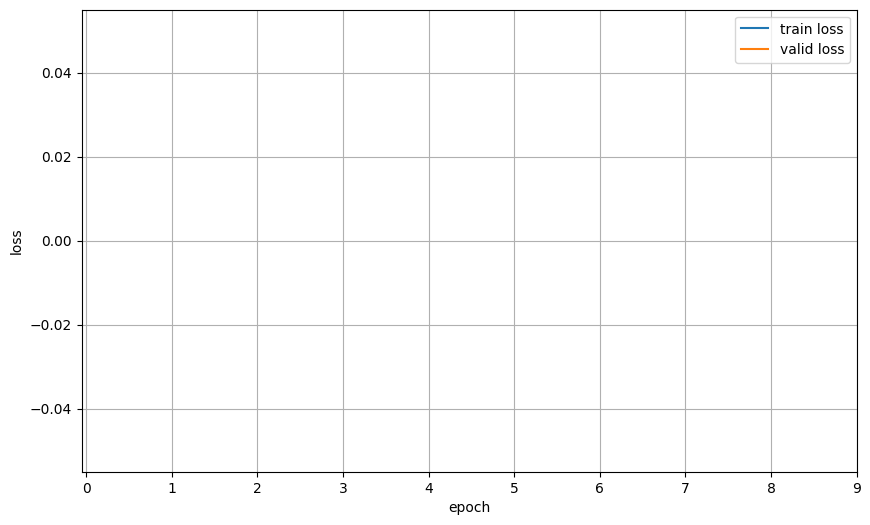

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

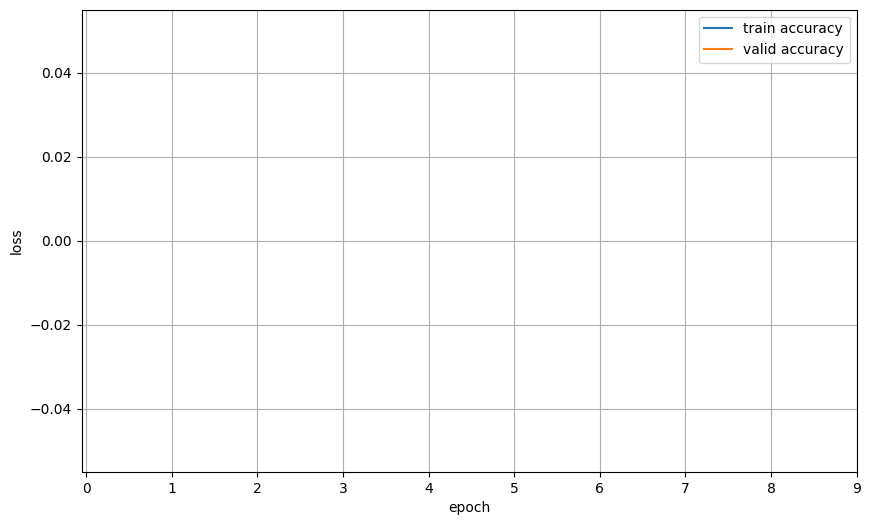

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [29]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [30]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [31]:
text = "This film is good!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5768982172012329)

In [32]:
text = "I have never seen something so unspectacular as this film. Its an absolute waste of time. There is no story, no acting, no nothing."

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5445840954780579)

In [33]:
text = "This film is the worst"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5913017988204956)

In [34]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5016263723373413)

In [35]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5172316431999207)

In [36]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5185278654098511)

In [37]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5580793619155884)

In [38]:
text = "What can I say? I ignored the reviews and went to see it myself. Damn the reviews were so right. What a waste of money considering it\'s budget.<br /><br />Good thing, I went to see Kill Bill after this one.<br /><br />To see a really scary movie, would be Crossroads!<br /><br />Bottom line-- I like Girl in Gold Boots better than this crap."

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5739524364471436)

In [39]:
text = "The Last Command (1928) is a silent film directed by Josef von Sternberg.It shows us Czarist General, Grand Duke Sergius Alexander (Emil Jannings) in his days of glory.In 1917 he had all the power but after the revolution and the collapse of Imperial Russia he has nothing.He also had the love of a woman, Natalie Dabrova (Evelyn Brent).About ten years later he applies for a small part in a film about the revolution.His old enemy Lev Andreyev (William Powell) is the director who gets to choose whether to hire him as a film extra or not.The Last Command is very good silent drama.Emil Jannings does memorable role work in the lead.Evelyn Brent is wonderful playing the woman lead.William Powell is great as always.There are plenty of scenes to remember in this movie.Like many scenes with Jannings and Brent.And then there is the ending with Powell and Jannings.This is a movie that touches in many parts."

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5531204342842102)

In [40]:
del model

## Exercise 1: LSTM

The model should not be bad yet (specially if pretrained embeddings are used). Can you replace the RNN with a LSTM and check the results.

In [41]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                          bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]

        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [42]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

lstm = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

print(f"The model has {count_parameters(lstm):,} trainable parameters")

The model has 10,101,302 trainable parameters


In [43]:
lstm.embedding.weight.data = pretrained_embedding

In [44]:
lr = 5e-4
optimizer = optim.Adam(lstm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

lstm = lstm.to(device)
criterion = criterion.to(device)
n_epochs = 10
best_valid_loss = float("inf")

metrics_lstm = collections.defaultdict(list)

In [45]:
for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, lstm, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, lstm, criterion, device)
    metrics_lstm["train_losses"].append(train_loss)
    metrics_lstm["train_accs"].append(train_acc)
    metrics_lstm["valid_losses"].append(valid_loss)
    metrics_lstm["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:13<00:00,  1.07s/it]


epoch: 0
train_loss: 0.630, train_acc: 0.627
valid_loss: 0.478, valid_acc: 0.769


evaluating...: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


epoch: 1
train_loss: 0.485, train_acc: 0.767
valid_loss: 0.415, valid_acc: 0.818


evaluating...: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


epoch: 2
train_loss: 0.416, train_acc: 0.817
valid_loss: 0.406, valid_acc: 0.843


evaluating...: 100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


epoch: 3
train_loss: 0.427, train_acc: 0.812
valid_loss: 0.484, valid_acc: 0.785


evaluating...: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


epoch: 4
train_loss: 0.383, train_acc: 0.830
valid_loss: 0.375, valid_acc: 0.852


evaluating...: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


epoch: 5
train_loss: 0.421, train_acc: 0.822
valid_loss: 0.517, valid_acc: 0.729


evaluating...: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


epoch: 6
train_loss: 0.402, train_acc: 0.831
valid_loss: 0.398, valid_acc: 0.826


evaluating...: 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


epoch: 7
train_loss: 0.354, train_acc: 0.849
valid_loss: 0.790, valid_acc: 0.660


evaluating...: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


epoch: 8
train_loss: 0.595, train_acc: 0.702
valid_loss: 0.451, valid_acc: 0.797


evaluating...: 100%|██████████| 13/13 [00:13<00:00,  1.04s/it]

epoch: 9
train_loss: 0.463, train_acc: 0.786
valid_loss: 0.436, valid_acc: 0.800


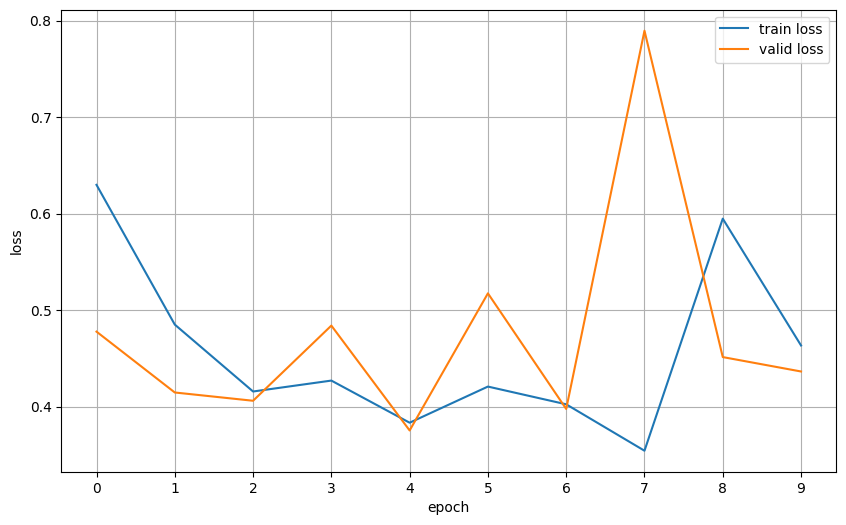

In [46]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics_lstm["train_losses"], label="train loss")
ax.plot(metrics_lstm["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

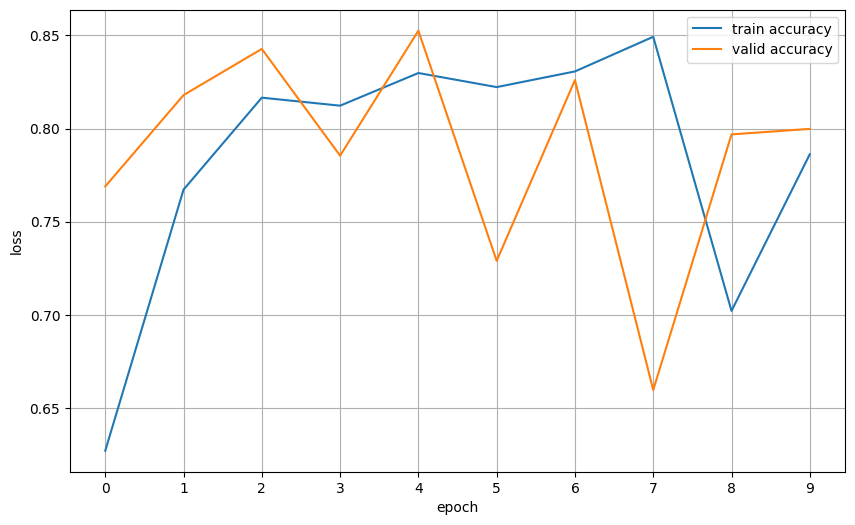

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics_lstm["train_accs"], label="train accuracy")
ax.plot(metrics_lstm["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [48]:
text = "This film is good!"

predict_sentiment(text, lstm, tokenizer, vocab, device)

(1, 0.5925216674804688)

In [49]:
text = "I have never seen something so unspectacular as this film. Its an absolute waste of time. There is no story, no acting, no nothing."

predict_sentiment(text, lstm, tokenizer, vocab, device)

(0, 0.9430722594261169)

## Exercise 2: Attention and Transformer (hard)

Even as this is not a seq2seq tasks, it would be possible to use attention and transformer ideas here. For example the encoder part and then just use a more simple decoder. 